# Simple Autoencoder

In [28]:
# Author: Vivian Wong
# Modified from Code by Sherlock Liao available at https://github.com/L1aoXingyu/pytorch-beginner?files=1

import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm


if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')
    
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 30
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

using device: cpu


In [18]:
def plot2D_with_labels(XY, labels):
    if type(XY)==torch.Tensor:
        XY = XY.numpy()
    plt.cla()
    X, Y = XY[:, 0], XY[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.show(); plt.pause(0.01)

In [19]:
def plot3D_with_labels(XYZ, labels):
    if type(XYZ)==torch.Tensor:
        XYZ = XYZ.numpy()
    fig = plt.figure(2); ax = Axes3D(fig)
    X, Y, Z = XYZ[:, 0].numpy(), XYZ[:, 1].numpy(), XYZ[:, 2].numpy() # put encoded data to [x,y,z]
    digits = train_data.train_labels[:200].numpy()
    for x, y, z, s in zip(X, Y, Z, digits):
        c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
    ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
    plt.show()

In [2]:
# train autoencoder
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        # ===================forward=====================
        encoded, decoded = model(img)
        loss = criterion(decoded, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(decoded.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))
        torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/30], loss:0.2028
epoch [2/30], loss:0.1903
epoch [3/30], loss:0.1867
epoch [4/30], loss:0.1629
epoch [5/30], loss:0.1770
epoch [6/30], loss:0.1623
epoch [7/30], loss:0.1731
epoch [8/30], loss:0.1832
epoch [9/30], loss:0.1733
epoch [10/30], loss:0.1625
epoch [11/30], loss:0.1508
epoch [12/30], loss:0.1623
epoch [13/30], loss:0.1483
epoch [14/30], loss:0.1579
epoch [15/30], loss:0.1647
epoch [16/30], loss:0.1605
epoch [17/30], loss:0.1623
epoch [18/30], loss:0.1602
epoch [19/30], loss:0.1620
epoch [20/30], loss:0.1590
epoch [21/30], loss:0.1643
epoch [22/30], loss:0.1594
epoch [23/30], loss:0.1499
epoch [24/30], loss:0.1519
epoch [25/30], loss:0.1566
epoch [26/30], loss:0.1451
epoch [27/30], loss:0.1582
epoch [28/30], loss:0.1577
epoch [29/30], loss:0.1539
epoch [30/30], loss:0.1632


In [3]:
torch.save(model.state_dict(), './sim_autoencoder.pth')

## View encoder output in 2D

In [23]:
view_data = dataset.data[:200].view(-1, 28*28).type(torch.FloatTensor)/255. # flatten each image to vector then normalize so max is max 1. 
encoded_data, _ = model(view_data)

digits = dataset.targets[:200].numpy()

In [24]:
print(encoded_data.shape)

torch.Size([200, 2])


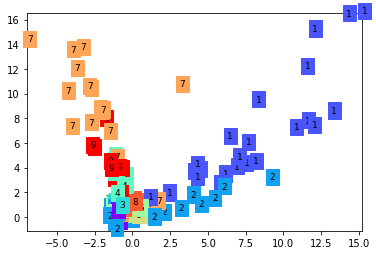

In [29]:
# view encoder output in 2D
plot2D_with_labels(encoded_data.data, digits)

### View encoder output using T-SNE

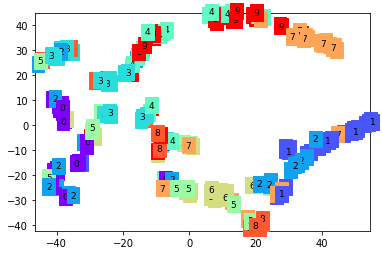

In [44]:
X = encoded_data.data.numpy()
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

plot2D_with_labels(X_embedded, digits)

# T-SNE (from scratch)

In [41]:
X = view_data # shape = (nsamples,nfeatures) = (200, 784)
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

(200, 2)

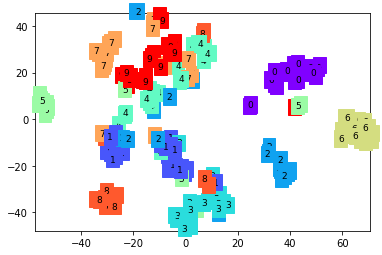

In [42]:
plot2D_with_labels(X_embedded, digits)